# Predicting the Status of Wells Across Tanzania

Exploration done by WellWatchers Avi Saraf, Lily Zhang, and Cindy Zhao.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

###Data preparation

In [2]:
df_values = pd.read_csv("clean_training_set_values.csv")
df_labels = pd.read_csv("training_set_labels.csv")

In [3]:
#merge the features (i.e. values) and the labels into one DataFrame
df = pd.merge(df_values, df_labels, on="id")

In [4]:
df.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,...,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,date_recorded_offset_days,date_recorded_month,status_group
0,69572,6000,Other,1390,Other,34.938093,-9.856322,Lake Nyasa,Mnyusi B,Iringa,...,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1024,Mar,functional
1,8776,0,Other,1399,Other,34.698766,-2.147466,Lake Victoria,Nyamara,Mara,...,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,301,Mar,functional
2,34310,25,Other,686,Other,37.460664,-3.821329,Pangani,Majengo,Manyara,...,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,310,Feb,functional
3,67743,0,Unicef,263,Other,38.486161,-11.155298,Ruvuma / Southern Coast,Mahakamani,Mtwara,...,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,338,Jan,non functional
4,19728,0,Other,0,Other,31.130847,-1.825359,Lake Victoria,Kyanyamisa,Kagera,...,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,903,Jul,functional


#Exploratory analysis

##Categorical Features

We have the following categorical variables:
- funder
- installer
- basin
- subvillage
- region
- scheme_management
- management
- management_group
- public_meeting (T/F)
- permit (T/F)
- extraction_type
- extraction_type_group
- extraction_type_class
- payment
- payment_type
- water_quality
- quality_group
- waterpoint_type
- waterpoint_type_group

Here we see the unique values under the columns with categorical values.

###Redundancies
We see that some of the columns describe the same feature but have slightly different sets of values. This is particularly the case with features that also have a corresponding '_ _group_' column as well. For now, we will stick with the non-gropu features because they are more specific.

In [5]:
print pd.Series(df.extraction_type.ravel()).unique()
#less specific
print pd.Series(df.extraction_type_group.ravel()).unique()
print pd.Series(df.extraction_type_class.ravel()).unique()

['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'ksb' 'mono' 'windmill' 'afridev' 'other - rope pump' 'india mark iii'
 'other - swn 81' 'other - play pump' 'cemo' 'climax' 'walimi']
['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'mono' 'wind-powered' 'afridev' 'rope pump' 'india mark iii'
 'other handpump' 'other motorpump']
['gravity' 'submersible' 'handpump' 'other' 'motorpump' 'wind-powered'
 'rope pump']


In [6]:
#equivalent
print pd.Series(df.payment.ravel()).unique()
print pd.Series(df.payment_type.ravel()).unique()

['pay annually' 'never pay' 'pay per bucket' 'unknown'
 'pay when scheme fails' 'other' 'pay monthly']
['annually' 'never pay' 'per bucket' 'unknown' 'on failure' 'other'
 'monthly']


In [7]:
#the difference here is the addition of 'communal standpipe multiple' in waterpoint_type
print pd.Series(df.waterpoint_type.ravel()).unique()
#less specific
print pd.Series(df.waterpoint_type_group.ravel()).unique()

['communal standpipe' 'communal standpipe multiple' 'hand pump' 'other'
 'improved spring' 'cattle trough' 'dam']
['communal standpipe' 'hand pump' 'other' 'improved spring' 'cattle trough'
 'dam']


In [8]:
print pd.Series(df.water_quality.ravel()).unique()
#less specific
print pd.Series(df.quality_group.ravel()).unique()

['soft' 'salty' 'milky' 'unknown' 'fluoride' 'coloured' 'salty abandoned'
 'fluoride abandoned']
['good' 'salty' 'milky' 'unknown' 'fluoride' 'colored']


In [9]:
#less specific
#'borehole' includes 'machine dbh' and 'hand dtw'
#'river/lake' includes 'river' and 'lake'
#'other' includes 'other' and 'unknown'
print pd.Series(df.source_type.ravel()).unique()
print pd.Series(df.source.values.ravel()).unique()
#source and source_type are nested within source_class
print pd.Series(df.source_class.values.ravel()).unique()

['spring' 'rainwater harvesting' 'dam' 'borehole' 'other' 'shallow well'
 'river/lake']
['spring' 'rainwater harvesting' 'dam' 'machine dbh' 'other' 'shallow well'
 'river' 'hand dtw' 'lake' 'unknown']
['groundwater' 'surface' 'unknown']


In [10]:
#management is nested within management_group
print pd.Series(df.management.ravel()).unique()
print pd.Series(df.management_group.ravel()).unique()

['vwc' 'wug' 'other' 'private operator' 'water board' 'wua' 'company'
 'water authority' 'parastatal' 'unknown' 'other - school' 'trust']
['user-group' 'other' 'commercial' 'parastatal' 'unknown']


We see that some of these features are redundant, so we delete one of the columns of these repeats. Regarding the features/feature_group label pairs, there is a nesting structure but it is so slight that we just delete one of the columns; otherwise, we would most likely run into problems of collinearity. We have two new dataframes, one with only the feature_group labels (less specific), and one with only the feature labels (more specific). We will try our regression on the less specific df_new first but keep df_new1 just in case.

In [5]:
df_new1 = df.drop(['quantity_group','extraction_type_group','waterpoint_type_group','quality_group','source_type','payment', 'construction_year','latitude','longitude', 'subvillage','id'], axis=1)
df_new = df.drop(['quantity_group','extraction_type','waterpoint_type','quality_group','source','payment', 'construction_year','latitude','longitude','subvillage','id'], axis=1)

In [6]:
df_new.head()

,amount_tsh,funder,gps_height,installer,basin,region,population,public_meeting,scheme_management,permit,...,management_group,payment_type,water_quality,quantity,source_type,source_class,waterpoint_type_group,date_recorded_offset_days,date_recorded_month,status_group
0,6000,Other,1390,Other,Lake Nyasa,Iringa,109,True,VWC,False,...,user-group,annually,soft,enough,spring,groundwater,communal standpipe,1024,Mar,functional
1,0,Other,1399,Other,Lake Victoria,Mara,280,NaN,Other,True,...,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,301,Mar,functional
2,25,Other,686,Other,Pangani,Manyara,250,True,VWC,True,...,user-group,per bucket,soft,enough,dam,surface,communal standpipe,310,Feb,functional
3,0,Unicef,263,Other,Ruvuma / Southern Coast,Mtwara,58,True,VWC,True,...,user-group,never pay,soft,dry,borehole,groundwater,communal standpipe,338,Jan,non functional
4,0,Other,0,Other,Lake Victoria,Kagera,0,True,NaN,True,...,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,903,Jul,functional


###Nestings

In df_new, we know that:
- management is nested within management_group
- source is nested within source_class
- extraction is nested within extraction_type_class
- subvillage is nested within region

###Grouping the types of categorical variables
The features dealing with the management of the well include:
- funder
- installer
- scheme_management
- management/management_group
- payment_type
- permit (T/F)

The features dealing with the creation of the well include:
- extraction/extraction_type_class
- waterpoint_type

The features dealing with time include: 
- construction_year
- date_recorded_offset_days (int; how long ago it was constructed, from the date recorded)
- date_recorded_month

The features dealing with natural properties include:
- water_quality
- source/source_class
- amount_tsh
- quantity
- basin

The features dealing with the community using the well and location include:
- subvillage
- region
- population
- public_meeting (T/F)
- gps_height
- longitude
- latitude

In [9]:
df_new.columns

Index([u'amount_tsh', u'funder', u'gps_height', u'installer', u'basin',
       u'subvillage', u'region', u'population', u'public_meeting',
       u'scheme_management', u'permit', u'extraction_type_group',
       u'extraction_type_class', u'management', u'management_group',
       u'payment_type', u'water_quality', u'quantity', u'source_type',
       u'source_class', u'waterpoint_type_group', u'date_recorded_offset_days',
       u'date_recorded_month', u'status_group'],
      dtype='object')

##Splitting the training and testing data


In [7]:
from sklearn.cross_validation import train_test_split
train, test = train_test_split(xrange(df_new.shape[0]), train_size=0.7)
mask=np.ones(df_new.shape[0])
mask[train]=1
mask[test]=0
mask = (mask==1)

##Standardize
Now standardize our quantitative variables so they can be compared. These variables are amount_tsh, gps_height, population, and date_recorded_offset_days.

In [8]:
from sklearn import preprocessing as prepr
STANDARDIZABLE = [u'amount_tsh', u'gps_height', u'population', u'date_recorded_offset_days']
scaler = prepr.StandardScaler().fit(df_new[mask][STANDARDIZABLE])
df_new[STANDARDIZABLE] = scaler.transform(df_new[STANDARDIZABLE])
df_new[STANDARDIZABLE].head()

,amount_tsh,gps_height,population,date_recorded_offset_days
0,2.245696,1.040760,-0.148724,1.141342
1,-0.120710,1.053747,0.208000,-1.024207
2,-0.110850,0.024832,0.145417,-0.997250
3,-0.120710,-0.585590,-0.255115,-0.913384
4,-0.120710,-0.965119,-0.376110,0.778919


##Visualizing the feature variables
Let's plot these variables now and see how their distributions differ across the functional, non functional, and needs repair wells. 

/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


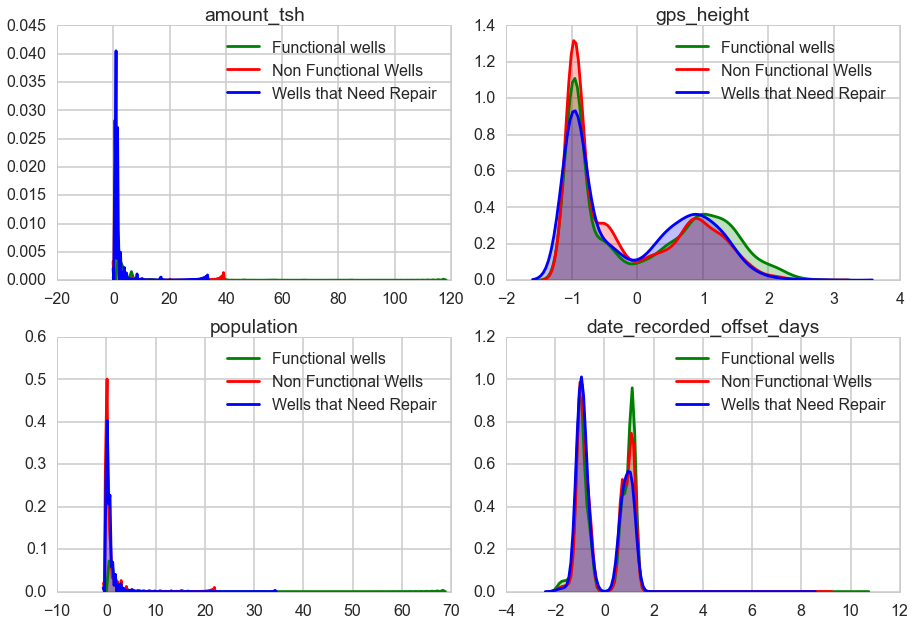

In [9]:
# fig, axes = plt.subplots(nrows=2, ncols=2)

# for i, feature in enumerate(STANDARDIZABLE):
#     ax = axes[i/2, i%2]
#     sns.kdeplot(df_new[df_new['status_group']=='functional'][feature], ax=ax, shade=True,color='green', label="Functional wells")
#     sns.kdeplot(df_new[df_new['status_group']=='non functional'][feature], ax=ax, shade=True,color='red', label="Non Functional Wells")
#     sns.kdeplot(df_new[df_new['status_group']=='functional needs repair'][feature], ax=ax, shade=True,color='blue', label="Wells that Need Repair")
#     ax.set_title(feature)

# fig.tight_layout()

We do the same for the categorical variables.

In [9]:
CATEGORICAL = [u'funder', u'installer', u'basin', u'region',
               u'public_meeting', u'scheme_management', u'permit',
               u'extraction_type_group', u'extraction_type_class',
               u'management', u'management_group', u'payment_type', u'water_quality',
               u'quantity', u'source_type', u'source_class', u'waterpoint_type_group', u'date_recorded_month']
for variable in CATEGORICAL:
    df_new[variable] = df_new[variable].astype('category')  

/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


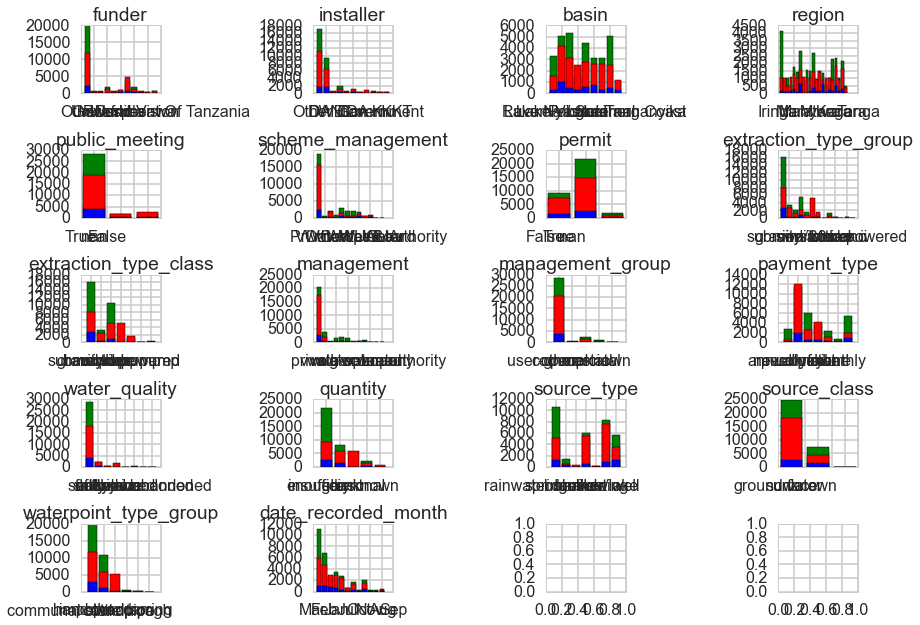

In [11]:
# fig1, axes1 = plt.subplots(5,4)

# plt.rc('xtick', labelsize=10) 
# plt.rc('ytick', labelsize=10) 
# for j, variable in enumerate(CATEGORICAL):
#     ax1 = axes1[j/4,j%4]
#     functional = df_new[df_new['status_group']=='functional'][variable].tolist()
#     non_functional = df_new[df_new['status_group']=='non functional'][variable].tolist()
#     needs_repair = df_new[df_new['status_group']=='functional needs repair'][variable].tolist()
#     categories = pd.Series(df_new[variable].values.ravel()).unique()
#     value_freq_funct = []
#     value_freq_nonf = []
#     value_freq_repair = []
#     categories_num = range(1,len(categories)+1)
#     for value in categories:
#         value_freq_funct.append(functional.count(value))
#         value_freq_nonf.append(non_functional.count(value))
#         value_freq_repair.append(needs_repair.count(value))
#     ax1.bar(categories_num,value_freq_funct,align='center',color='g')
#     ax1.bar(categories_num,value_freq_nonf,align='center',color='r')
#     ax1.bar(categories_num,value_freq_repair,align='center',color='b')
#     ax1.set_xticklabels(categories)
#     ax1.legend()
#     ax1.set_title(variable)

# plt.tight_layout()

Let's take a closer look at some of them. In particular, ___ seem to show very interesting distributions.

In [80]:
#TODO

In [12]:
##To run
#for subvillages
# functional = df_new[df_new['status_group']=='functional']['subvillage'].tolist()
# non_functional = df_new[df_new['status_group']=='non functional']['subvillage'].tolist()
# needs_repair = df_new[df_new['status_group']=='functional needs repair']['subvillage'].tolist()

# plt.rc('xtick', labelsize=12) 
# plt.rc('ytick', labelsize=12)

# categories = pd.Series(df_new.subvillage.values.ravel()).unique()
# value_freq_funct = []
# value_freq_nonf = []
# value_freq_repair = []
# categories_num = range(1,len(categories)+1)
# for value in categories:
#     value_freq_funct.append(functional.count(value))
#     value_freq_nonf.append(non_functional.count(value))
#     value_freq_repair.append(needs_repair.count(value))
# fig, [ax1, ax2, ax3] = plt.subplots(3, 1)
# ax1.bar(categories_num,value_freq_funct,align='center',color='g')
# ax2.bar(categories_num,value_freq_nonf,align='center',color='r')
# ax3.bar(categories_num,value_freq_repair,align='center',color='b')
#plt.xticks(categories_num, categories)

([<matplotlib.axis.XTick at 0x109e18450>,
 <a list of 11 Text xticklabel objects>)

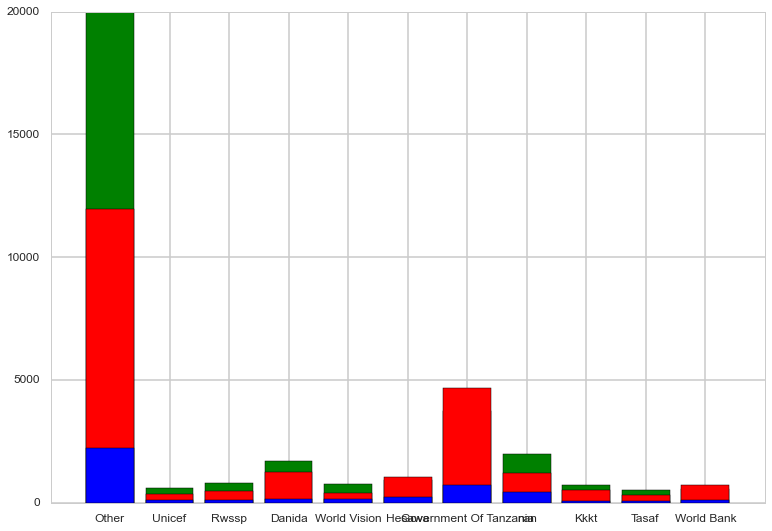

In [10]:
#for funders
functional = df_new[df_new['status_group']=='functional']['funder'].tolist()
non_functional = df_new[df_new['status_group']=='non functional']['funder'].tolist()
needs_repair = df_new[df_new['status_group']=='functional needs repair']['funder'].tolist()

plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)

categories = pd.Series(df_new.funder.values.ravel()).unique()
value_freq_funct = []
value_freq_nonf = []
value_freq_repair = []
categories_num = range(1,len(categories)+1)
for value in categories:
    value_freq_funct.append(functional.count(value))
    value_freq_nonf.append(non_functional.count(value))
    value_freq_repair.append(needs_repair.count(value))
fig.set_size_inches(8, 5)
plt.bar(categories_num,value_freq_funct,align='center',color='g')
plt.bar(categories_num,value_freq_nonf,align='center',color='r')
plt.bar(categories_num,value_freq_repair,align='center',color='b')
plt.xticks(categories_num, categories)

In [92]:
pd.Series(df.funder.values.ravel()).unique()

array(['Other', 'Unicef', 'Rwssp', 'Danida', 'World Vision', 'Hesawa',
       'Government Of Tanzania', nan, 'Kkkt', 'Tasaf', 'World Bank'], dtype=object)

#Models


Recall that we found 19 categorical features in this data set. While we could encode these variables as ordinal numbers, our classifying algorithms expect a continuous input. Therefore, we turn to one-of-K, or one-hot, encoding to transform each categorical feature with $m$ possible values into $m$ binary features, of which only one is active.

In [10]:
df_formatted = pd.get_dummies(df_new, columns=CATEGORICAL)
df_formatted.head()

,amount_tsh,gps_height,population,date_recorded_offset_days,status_group,funder_Danida,funder_Government Of Tanzania,funder_Hesawa,funder_Kkkt,funder_Other,...,date_recorded_month_Dec,date_recorded_month_Feb,date_recorded_month_Jan,date_recorded_month_Jul,date_recorded_month_Jun,date_recorded_month_Mar,date_recorded_month_May,date_recorded_month_Nov,date_recorded_month_Oct,date_recorded_month_Sep
0,2.245696,1.040760,-0.148724,1.141342,functional,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,-0.120710,1.053747,0.208000,-1.024207,functional,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,-0.110850,0.024832,0.145417,-0.997250,functional,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,-0.120710,-0.585590,-0.255115,-0.913384,non functional,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,-0.120710,-0.965119,-0.376110,0.778919,functional,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [11]:
lcols = list(df_formatted.columns)
lcols.remove(u'status_group')
print len(lcols)

154


In [12]:
feat_matrix = df_formatted[lcols].values
lab_resp = df_formatted['status_group'].values

feat_train = feat_matrix[mask]
feat_test = feat_matrix[~mask]
lab_train = lab_resp[mask]
lab_test = lab_resp[~mask]

In [21]:
# #feat_train and lab_train analogous to Xtrain and ytrain
# feat_train = df_formatted[mask].drop('status_group',axis=1).values
# lab_train = pd.DataFrame(df_formatted[mask].status_group).values
# ##feat_test and lab_test analogous to Xtrain and ytrain
# feat_test = df_formatted[~mask].drop('status_group',axis=1).values
# lab_test = pd.DataFrame(df_formatted[~mask].status_group).values

In [13]:
print feat_train.shape
print lab_train.shape

(41580, 154)
(41580,)


## SVM

Bearing in mind that we have a large sample size, we begin by implementing a linear SVM, explicitly passing in the standard SVM hinge loss. We choose to begin here as the kernalized SVM training time that we will attempt later scales with the sample size, and we want to quickly classify on all features as a baseline. 

We will later move to classify using feature-selection, as well as balancing. Finally, we proceed to implement a kernalized SVM. 

To summarize, we experiment with the following optimizations:
- linear and kernalized SVM
- balanced labels
- loss function (hinge and squared-hinge here)
- feature-selection

In [14]:
from sklearn.svm import LinearSVC

In [18]:
# #Lily's version
# def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
#     gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
#     gs.fit(X, y)
#     print "BEST:", gs.best_params_
#     return gs.best_estimator_

In [15]:
def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

In [16]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=indf[targetname].values#(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [17]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [74]:
print xx.shape, yy.shape

(100, 100) (100, 100)


In [71]:
## figuring out error in points plot
#points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm);
ax = ax
Xtr = Xtrain
Xte = Xtest
ytr = ytrain 
yte = ytest
clf = clfsvm
mesh=True
colorscale=cmap_light
cdiscrete=cmap_bold
alpha=0.3
psize=10
zfunc=False

h = .02
X=np.concatenate((Xtr, Xte))
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

#plt.figure(figsize=(10,6))
if mesh:
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
#         print xx.ravel()
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)
#     plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
# ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
# # and testing points
# yact=clf.predict(Xte)
# ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
# ax.set_xlim(xx.min(), xx.max())
# ax.set_ylim(yy.min(), yy.max())

ValueError: X has 2 features per sample; expecting 154

In [70]:
np.c_[xx.ravel(), yy.ravel()]

array([[  -0.6207102 ,   -1.5949964 ],
       [   0.78373801,   -1.5949964 ],
       [   2.18818623,   -1.5949964 ],
       ..., 
       [ 135.61076634,    3.53220794],
       [ 137.01521456,    3.53220794],
       [ 138.41966277,    3.53220794]])

In [18]:
clfsvm=LinearSVC(loss="hinge")
Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

In [19]:
gs=GridSearchCV(clfsvm, param_grid={'C':Cs}, cv=5)
gs.fit(feat_train, lab_train)
print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_

# calculate accuracy
best = gs.best_estimator_
best.fit(feat_train, lab_train)
best.score(feat_test, lab_test)

BEST {'C': 10.0} 0.722943722944 [mean: 0.69913, std: 0.00516, params: {'C': 0.001}, mean: 0.71907, std: 0.00555, params: {'C': 0.01}, mean: 0.72095, std: 0.00897, params: {'C': 0.1}, mean: 0.72061, std: 0.00988, params: {'C': 1.0}, mean: 0.72294, std: 0.00751, params: {'C': 10.0}, mean: 0.62280, std: 0.07041, params: {'C': 100.0}]


0.72643097643097643

In [21]:
%%time
# classify using linear SVM again, but with function this time
# note: this should give the same answer as above
linearsvm, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df_formatted, lcols, 'status_group',1, mask=mask)

using mask
BEST {'C': 10.0} 0.723136123136 [mean: 0.69913, std: 0.00516, params: {'C': 0.001}, mean: 0.71907, std: 0.00555, params: {'C': 0.01}, mean: 0.72092, std: 0.00897, params: {'C': 0.1}, mean: 0.72076, std: 0.01000, params: {'C': 1.0}, mean: 0.72314, std: 0.00739, params: {'C': 10.0}, mean: 0.65794, std: 0.02003, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.72
Accuracy on test data:     0.73
[[9103    0  688]
 [1108    0  191]
 [2859    0 3871]]
########################################################
CPU times: user 7min 40s, sys: 2.99 s, total: 7min 43s
Wall time: 7min 50s


/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [22]:
# for purposes of comparison with SVM optimization later
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

We also experiment with a squared hinge loss function, rather than the usual hinge loss function.

In [24]:
%%time
# loss function is now squared_hinge
linearsvm2, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="squared_hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df_formatted, lcols, 'status_group',1, mask=mask)

using mask
BEST {'C': 1.0} 0.732275132275 [mean: 0.72787, std: 0.00555, params: {'C': 0.001}, mean: 0.73148, std: 0.00533, params: {'C': 0.01}, mean: 0.73191, std: 0.00538, params: {'C': 0.1}, mean: 0.73228, std: 0.00539, params: {'C': 1.0}, mean: 0.73215, std: 0.00529, params: {'C': 10.0}, mean: 0.64798, std: 0.05918, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.73
Accuracy on test data:     0.73
[[8901    1  889]
 [1070    8  221]
 [2582    2 4146]]
########################################################
CPU times: user 14min 18s, sys: 8.23 s, total: 14min 26s
Wall time: 14min 54s


/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


### SVM Optimized for Feature Selection

With the number of features that we have and the related indicator variables, there is almost certainly a strong correlation between features. Therefore, we are subject to the curse of dimensionality and wish to more carefully select our features by more closely inspecting pearson correlation coefficients first. 

In [25]:
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

In [78]:
# create dictionary that maps each of the statuses to a number for future interpretation purposes
status_dict = {'non functional': 0, 'functional needs repair': 0.5, 'functional': 1}
status_dict2 = {'non functional': 0, 'functional needs repair': 1, 'functional': 2}

In [79]:
# create a new data frame that is the same as the original df_formatted, except with the replaced status numbers
df_lab_change = df_formatted.replace({'status_group': status_dict})
df_lab_change2 = df_formatted.replace({'status_group': status_dict2})

In [82]:
from scipy.stats.stats import pearsonr
# get correlation coefficients for each of the features
correlations=[]
dftousetrain=df_formatted[mask]
lab_compare=df_formatted[mask].replace({'status_group': status_dict2}, inplace=False)['status_group']
for col in lcols:
    r=pearsonr(dftousetrain[col], lab_compare)[0]
    correlations.append(dict(feature=col,corr=r, abscorr=np.abs(r)))

# sort correlations and place the most correlated/anti-correlated in a new list of columns to use
bpdf2=pd.DataFrame(correlations).sort('abscorr', ascending=False)
bpdf2.set_index(['feature'], inplace=True)
newlcols2 = list(bpdf2.head(50).index.get_values())
bpdf2.head(10)

,abscorr,corr
feature,,
quantity_dry,0.398278,-0.398278
waterpoint_type_group_other,0.309078,-0.309078
extraction_type_group_other,0.297264,-0.297264
extraction_type_class_other,0.297264,-0.297264
quantity_enough,0.260849,0.260849
payment_type_never pay,0.167253,-0.167253
water_quality_unknown,0.159990,-0.159990
region_Iringa,0.143773,0.143773
extraction_type_group_gravity,0.139797,0.139797


In [77]:
bpdf.head(50)

,abscorr,corr
feature,,
quantity_dry,0.398278,-0.398278
waterpoint_type_group_other,0.309078,-0.309078
extraction_type_group_other,0.297264,-0.297264
extraction_type_class_other,0.297264,-0.297264
quantity_enough,0.260849,0.260849
payment_type_never pay,0.167253,-0.167253
water_quality_unknown,0.159990,-0.159990
region_Iringa,0.143773,0.143773
extraction_type_group_gravity,0.139797,0.139797


In [29]:
from scipy.stats.stats import pearsonr
# get correlation coefficients for each of the features
correlations=[]
dftousetrain=df_formatted[mask]
lab_compare=df_formatted[mask].replace({'status_group': status_dict}, inplace=False)['status_group']
for col in lcols:
    r=pearsonr(dftousetrain[col], lab_compare)[0]
    correlations.append(dict(feature=col,corr=r, abscorr=np.abs(r)))

# sort correlations and place the most correlated/anti-correlated in a new list of columns to use
bpdf=pd.DataFrame(correlations).sort('abscorr', ascending=False)
bpdf.set_index(['feature'], inplace=True)
newlcols = list(bpdf.head(50).index.get_values())

print newlcols

[u'quantity_dry', u'waterpoint_type_group_other', u'extraction_type_group_other', u'extraction_type_class_other', u'quantity_enough', u'payment_type_never pay', u'water_quality_unknown', u'region_Iringa', u'extraction_type_group_gravity', u'extraction_type_class_gravity', u'water_quality_soft', u'management_vwc', 'gps_height', u'payment_type_monthly', u'funder_Government Of Tanzania', u'source_type_spring', u'payment_type_annually', u'basin_Ruvuma / Southern Coast', u'extraction_type_class_handpump', u'payment_type_per bucket', u'payment_type_unknown', u'waterpoint_type_group_communal standpipe', u'extraction_type_group_nira/tanira', u'management_water board', u'funder_Other', u'region_Lindi', u'waterpoint_type_group_hand pump', u'region_Mtwara', u'extraction_type_group_mono', u'extraction_type_class_motorpump', u'scheme_management_Water Board', u'scheme_management_VWC', u'installer_Government', u'date_recorded_month_Mar', u'installer_RWE', u'public_meeting_True', u'source_type_shallow

In [56]:
%%time
# linear SVM with feature-selection and squared hinge
# clfsvm, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="squared_hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df_formatted, newlcols, 'status_group',1, mask=mask)
clfsvm, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="squared_hinge"), {"C": [10.0, 100.0]}, df_formatted, newlcols, 'status_group',1, reuse_split=reuse_split)

using reuse split
BEST {'C': 10.0} 0.730687830688 [mean: 0.73069, std: 0.00601, params: {'C': 10.0}, mean: 0.68042, std: 0.01875, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.73
Accuracy on test data:     0.73
[[8939    5  847]
 [1083   10  206]
 [2620    6 4104]]
########################################################
CPU times: user 7min 16s, sys: 4.4 s, total: 7min 20s
Wall time: 7min 35s


In [57]:
#From Jake Vanderplas's ESAC notebook
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    return ax.contour(X, Y, P, colors='k',
                      levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'])

ValueError: X has 2 features per sample; expecting 154

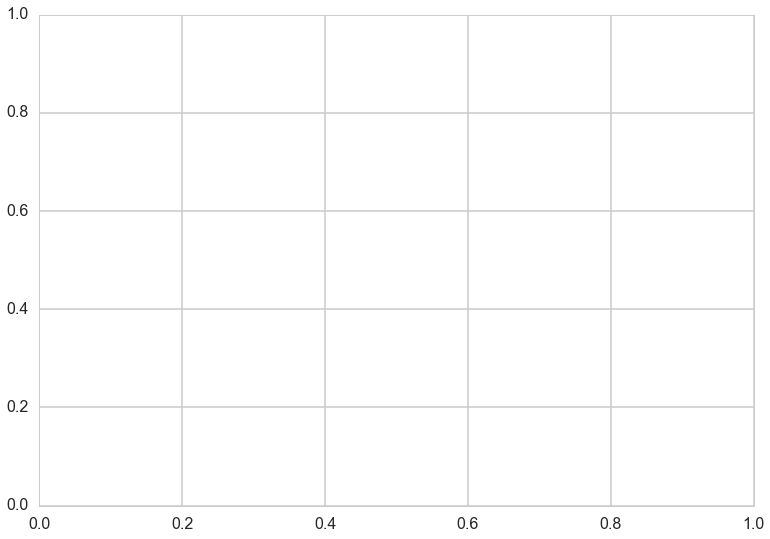

In [58]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm);
plot_svc_decision_function(clfsvm, ax)
ax.scatter(clfsvm.support_vectors_[:, 0], clfsvm.support_vectors_[:, 1],s=200, facecolors='none')
plt.ylim([125,225])

ValueError: X has 2 features per sample; expecting 50

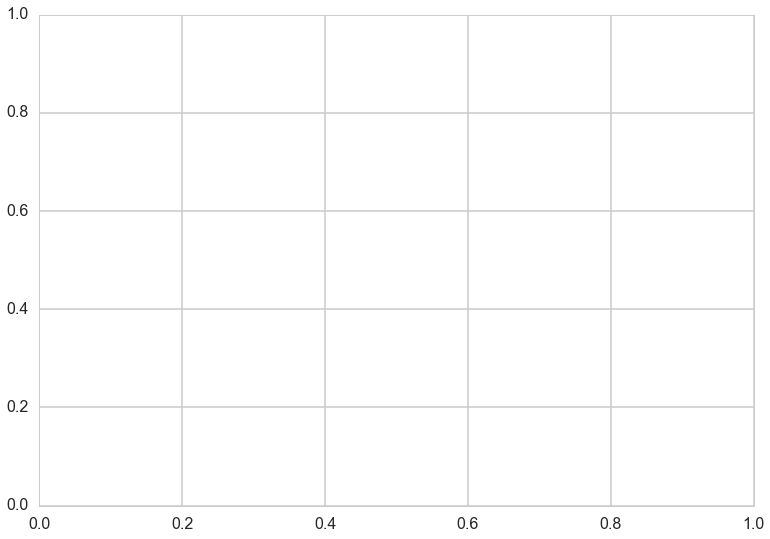

In [31]:
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm);

In [32]:
%%time
# linear SVM with feature-selection reusing the previous split for comparison purposes
clfsvm, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df_formatted, newlcols, 'status_group',1, reuse_split=reuse_split)

using reuse split
BEST {'C': 10.0} 0.722895622896 [mean: 0.69913, std: 0.00516, params: {'C': 0.001}, mean: 0.71907, std: 0.00555, params: {'C': 0.01}, mean: 0.72092, std: 0.00897, params: {'C': 0.1}, mean: 0.71999, std: 0.00909, params: {'C': 1.0}, mean: 0.72290, std: 0.00753, params: {'C': 10.0}, mean: 0.60856, std: 0.04911, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.73
Accuracy on test data:     0.73
[[9114    0  677]
 [1114    0  185]
 [2859    0 3871]]
########################################################
CPU times: user 7min 53s, sys: 4.21 s, total: 7min 57s
Wall time: 8min 9s


In [27]:
def pearson_scorer(X,y):
    rs=np.zeros(X.shape[1])
    pvals=np.zeros(X.shape[1])
    i=0
    for v in X.T:
        rs[i], pvals[i]=pearsonr(v, y)
        i=i+1
    return np.abs(rs), pvals    

In [62]:
# select for the k=50 most correlated/anti-correlated features
selectorlinearsvm = SelectKBest(k=50, score_func=pearson_scorer)
pipelinearsvm = Pipeline([('select', selectorlinearsvm), ('svm', LinearSVC(loss="hinge"))])

In [77]:
# pipelinearsvm, _,_,_,_  = do_classify(pipelinearsvm, {"svm__C": [0.00001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df_lab_change, lcols, 'status_group', 1, mask=mask)#, reuse_split=reuse_split)

In [78]:
# #Here are the selected features:
# np.array(lcols)[pipelinearsvm.get_params()['select'].get_support()]

### SVM Optimized for Balancing and Feature Selection

In [33]:
# get current lengths of each label to check the necessity of balancing
jtrain=np.arange(0, lab_train.shape[0])
func=len(jtrain[lab_train=='functional'])
repair=len(jtrain[lab_train=='functional needs repair'])
nonfunc=len(jtrain[lab_train=='non functional'])
print func, repair, nonfunc

22468 3018 16094


In [34]:
# randomly pick indices for each of 'functional' and 'non functional'
pick_func = np.random.choice(jtrain[lab_train=='functional'], repair, replace=False)
pick_nonfunc = np.random.choice(jtrain[lab_train=='non functional'], repair, replace=False)

In [35]:
indices = np.concatenate((pick_func, jtrain[lab_train=='functional needs repair'], pick_nonfunc))

In [36]:
feat_train_balanced = feat_train[indices]
lab_train_balanced = lab_train[indices]
print feat_train_balanced.shape, lab_train_balanced.shape

(9054, 154) (9054,)


In [37]:
reuse_split_balanced=dict(Xtrain=feat_train_balanced, Xtest=feat_test, ytrain=lab_train_balanced, ytest=lab_test)

In [38]:
%%time
clfsvm, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df_formatted, newlcols, 'status_group',1, reuse_split=reuse_split_balanced)

using reuse split
BEST {'C': 10.0} 0.617075325823 [mean: 0.59112, std: 0.01286, params: {'C': 0.001}, mean: 0.60758, std: 0.01105, params: {'C': 0.01}, mean: 0.61100, std: 0.00763, params: {'C': 0.1}, mean: 0.61387, std: 0.00911, params: {'C': 1.0}, mean: 0.61708, std: 0.00899, params: {'C': 10.0}, mean: 0.53799, std: 0.05011, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.63
Accuracy on test data:     0.61
[[6278 2715  798]
 [ 329  867  103]
 [1727 1356 3647]]
########################################################
CPU times: user 38.5 s, sys: 226 ms, total: 38.7 s
Wall time: 38.8 s


### Kernalized SVM

Ideally, our SVM wouldn't be confined to a linear operation, so we now tray a Radial Basis Function Kernel.

(To consider: run a smaller subsample with less regularization and on the selected features, but in the end, we want to run it on all features with strong regularization.)

(Note from HW 3:  The RBF kernel has two parameters `C`, which controls the number of support vectors: large `C`s (low regularization) mean many more support vectors; and $\gamma$, which is in the inverse square radius of the RBF kernel. A small $\gamma$ means a large radius scale, and favors smoother, less curved classifications. There is a tradeoff between the two, which you can read about here: http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html . Models with high C tend to take a lot of time to run (hours->days on my laptop), so we shall, in the interests of time fix the $C$, OR the support vectors allowed us at a reasonably large value and cross-validate only on $\gamma$.)

In [39]:
from sklearn.svm import SVC

In [40]:
svm2=SVC()

In [52]:
%%time
# run RBF kernel on a multitiude of parameters
svm2, Xtrain, ytrain, Xtest, ytest = do_classify(SVC(), {"C": [1e0, 1e2, 1e8],"gamma":[1e2, 1e0, 1e-2, 1e-5, 1e-7, 1e-9]}, df_formatted, newlcols, 'status_group', 1, reuse_split=reuse_split_balanced)

using reuse split
BEST {'C': 100.0, 'gamma': 0.01} 0.676496576099 [mean: 0.52960, std: 0.00961, params: {'C': 1.0, 'gamma': 100.0}, mean: 0.62238, std: 0.01388, params: {'C': 1.0, 'gamma': 1.0}, mean: 0.62834, std: 0.01314, params: {'C': 1.0, 'gamma': 0.01}, mean: 0.49061, std: 0.01837, params: {'C': 1.0, 'gamma': 1e-05}, mean: 0.49006, std: 0.01864, params: {'C': 1.0, 'gamma': 1e-07}, mean: 0.44014, std: 0.02242, params: {'C': 1.0, 'gamma': 1e-09}, mean: 0.53159, std: 0.01148, params: {'C': 100.0, 'gamma': 100.0}, mean: 0.62812, std: 0.01632, params: {'C': 100.0, 'gamma': 1.0}, mean: 0.67650, std: 0.00736, params: {'C': 100.0, 'gamma': 0.01}, mean: 0.58670, std: 0.01508, params: {'C': 100.0, 'gamma': 1e-05}, mean: 0.49006, std: 0.01864, params: {'C': 100.0, 'gamma': 1e-07}, mean: 0.44014, std: 0.02242, params: {'C': 100.0, 'gamma': 1e-09}, mean: 0.49072, std: 0.01514, params: {'C': 100000000.0, 'gamma': 100.0}, mean: 0.48896, std: 0.00574, params: {'C': 100000000.0, 'gamma': 1.0}, mea

In [54]:
%%time
# now try running RBF kernel on the entire data set (not balanced necessarily) for optimal parameters
svm2, Xtrain, ytrain, Xtest, ytest = do_classify(SVC(), {"C": [1e2],"gamma":[1e-2]}, df_formatted, newlcols, 'status_group', 1, reuse_split=reuse_split)

using reuse split
BEST {'C': 100.0, 'gamma': 0.01} 0.779268879269 [mean: 0.77927, std: 0.00386, params: {'C': 100.0, 'gamma': 0.01}]
############# based on standard predict ################
Accuracy on training data: 0.81
Accuracy on test data:     0.78
[[8855  121  815]
 [ 805  306  188]
 [1885   78 4767]]
########################################################
CPU times: user 1h 18min 15s, sys: 40.7 s, total: 1h 18min 55s
Wall time: 3h 4min 50s


In [53]:
%%time
# also try running RBF kernel on the balanced data set (not balanced necessarily) for optimal parameters and entire feature set
svm2, Xtrain, ytrain, Xtest, ytest = do_classify(SVC(), {"C": [1e2],"gamma":[1e-2]}, df_formatted, lcols, 'status_group', 1, reuse_split=reuse_split_balanced)

using reuse split
BEST {'C': 100.0, 'gamma': 0.01} 0.676496576099 [mean: 0.67650, std: 0.00736, params: {'C': 100.0, 'gamma': 0.01}]
############# based on standard predict ################
Accuracy on training data: 0.78
Accuracy on test data:     0.66
[[6421 2218 1152]
 [ 267  938   94]
 [1284 1074 4372]]
########################################################
CPU times: user 3min 15s, sys: 2.73 s, total: 3min 18s
Wall time: 3min 23s


In [55]:
%%time
# now try running RBF kernel on the entire data set (not balanced necessarily) for optimal parameters and entire feature set
svm2, Xtrain, ytrain, Xtest, ytest = do_classify(SVC(), {"C": [1e2],"gamma":[1e-2]}, df_formatted, lcols, 'status_group', 1, reuse_split=reuse_split)

using reuse split
BEST {'C': 100.0, 'gamma': 0.01} 0.779268879269 [mean: 0.77927, std: 0.00386, params: {'C': 100.0, 'gamma': 0.01}]
############# based on standard predict ################
Accuracy on training data: 0.81
Accuracy on test data:     0.78
[[8855  121  815]
 [ 805  306  188]
 [1885   78 4767]]
########################################################
CPU times: user 1h 20min 1s, sys: 56.2 s, total: 1h 20min 57s
Wall time: 1h 23min 38s


In [ ]:
%%time
## THIS IS NEW
# now try running RBF kernel on all labels (not balanced) for optimal parameters and selected feature set for a higher C
svm2, Xtrain, ytrain, Xtest, ytest = do_classify(SVC(), {"C": [1e2],"gamma":[1e-2]}, df_formatted, lcols, 'status_group', 1, reuse_split=reuse_split)

In [76]:
%%time
## THIS IS NEW AS WELL
## POLYNOMIAL KERNEL
# now try running polynomial kernel on the entire data set (not balanced necessarily) for optimal parameters and entire feature set
polysvm, Xtrain, ytrain, Xtest, ytest = do_classify(SVC(degree=3), {"C": [1e2],"gamma":[1e-2]}, df_formatted, lcols, 'status_group', 1, reuse_split=reuse_split)

using reuse split
BEST {'C': 100.0, 'gamma': 0.01} 0.779268879269 [mean: 0.77927, std: 0.00386, params: {'C': 100.0, 'gamma': 0.01}]


KeyboardInterrupt: 

### Results and Comparison of Optimizations

We now compare our resulting optimizations with an ROC curve.

In [59]:
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

ValueError: bad input shape (17820, 3)

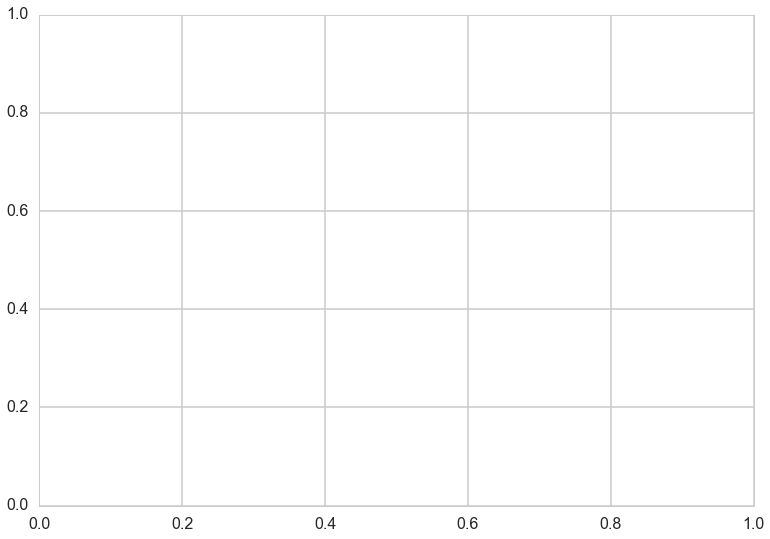

In [62]:
with sns.color_palette("bright"):
    ax=make_roc("svm-all-features",clfsvm, ytest, Xtest, None, labe=250, proba=False, skip=50)
    make_roc("svm-feature-selected",pipelinearsvm, ytest, Xtest, ax, labe=250, proba=False, skip=50);
#     make_roc("logistic-with-lasso",clflog, ytest, Xtest, ax, labe=250, proba=True,  skip=50);

## kNN

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split

In [95]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [42]:
def classify(X,y, nbrs, result=True, plotit=False, train_size=0.6):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf= KNeighborsClassifier(nbrs)
    clf=clf.fit(Xtrain, ytrain)
    #in sklearn accuracy can be found by using "score". It predicts and then gets the accuracy
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    Xall=np.concatenate((Xtrain, Xtest))
    if result:
        print "Accuracy on training data: %0.2f" % (training_accuracy)
        print "Accuracy on test data:     %0.2f" % (test_accuracy)
    if plotit: 
        plt.figure()
        ax=plt.gca()
        points_plot(ax, Xtrain, Xtest, ytrain, ytest, clf, alpha=0.3, psize=20)
    return nbrs, training_accuracy, test_accuracy

In order to more clearly visualize a kNN algorithm, we first classify in a reduced feature space with two features.
The features were again picked, as before, based on their correlations. 

of the quantitative features. (In reality, we tested all combinations of the $\binom{4}{2}$ quantitative features and picked one of the more consistently accurate classifications.) 

For contrast's sake and an enhanced intuition, we classified and plotted with first 1 neighbor and then 50 neighbors.

In [43]:
twofeats=list(bpdf.head(2).index.get_values())
print twofeats

[u'quantity_dry', u'waterpoint_type_group_other']


Accuracy on training data: 0.59
Accuracy on test data:     0.55


(1, 0.58510101010101012, 0.55025252525252522)

/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


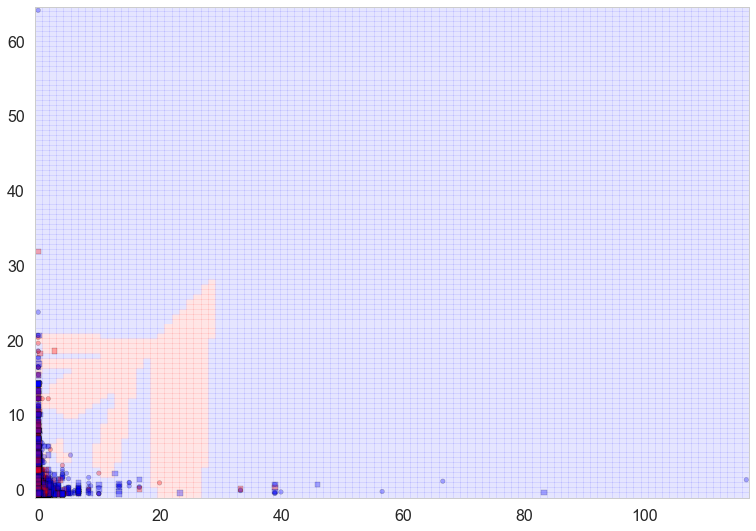

In [44]:
# select and plot two quantitative features
ys=df_lab_change['status_group'].astype(int).values
# subdf=df_lab_change[['amount_tsh','gps_height','population','date_recorded_offset_days']]
# subdf=df_lab_change[['amount_tsh','gps_height']]
subdf=df_lab_change[['amount_tsh','population']]
# subdf=df_lab_change[['amount_tsh','date_recorded_offset_days']]
# subdf=df_lab_change[['gps_height', 'population']]
# subdf=df_lab_change[['gps_height', 'date_recorded_offset_days']]
# subdf=df_lab_change[['population','date_recorded_offset_days']]
subdfstd=(subdf - subdf.mean())/subdf.std()
Xs2quant=subdfstd.values

classify(Xs2quant,ys,1,plotit=True)

In [45]:
# select two features using largest abs(correlation coefficient)
ys=df_lab_change['status_group'].astype(int).values
# subdf=df_lab_change[['amount_tsh','gps_height','population','date_recorded_offset_days']]
# subdf=df_lab_change[['amount_tsh','date_recorded_offset_days']]
subdf=df_lab_change[twofeats]
subdfstd=(subdf - subdf.mean())/subdf.std()
Xs2=subdfstd.values

Accuracy on training data: 0.45
Accuracy on test data:     0.46


(1, 0.45476992143658812, 0.46014309764309763)

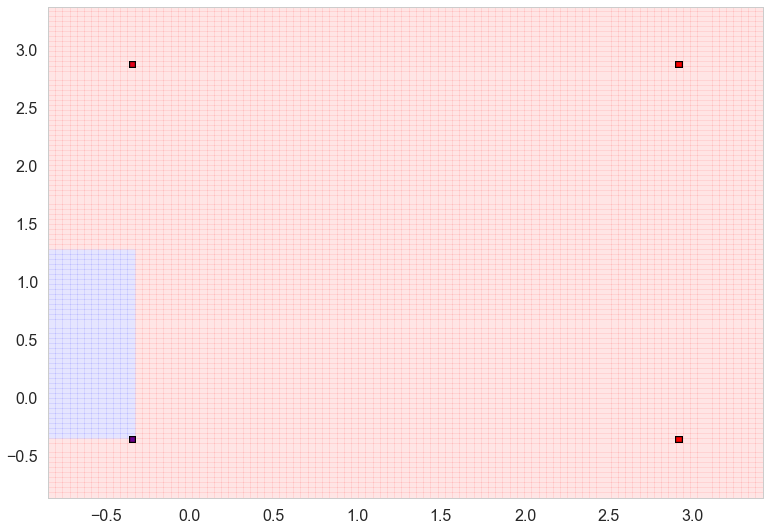

In [46]:
classify(Xs2,ys,1,plotit=True)

Accuracy on training data: 0.70
Accuracy on test data:     0.70


(50, 0.70042087542087539, 0.69654882154882158)

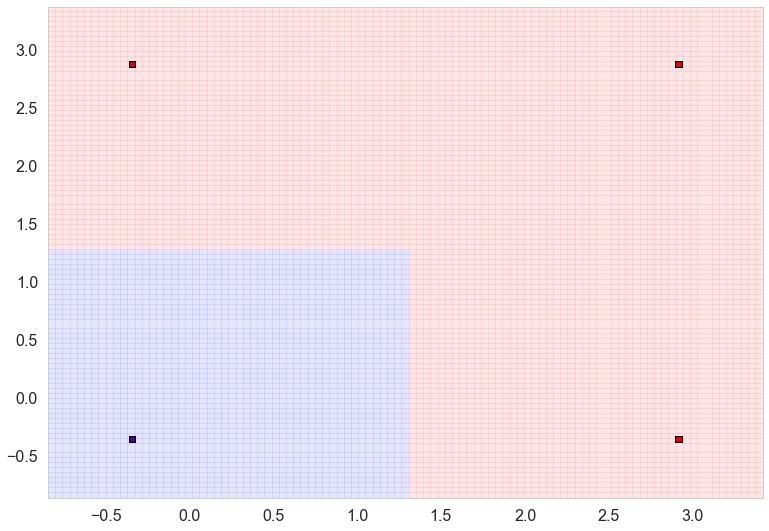

In [47]:
classify(Xs2,ys,50,plotit=True)#run this a few times

In [142]:
fits={}
for k in np.arange(1,45,5):
    fits[k]=[]
    for i in range(200):
        fits[k].append(classify(Xs, ys,k, result=False, plotit=False))
nbrs=np.arange(1,45,1)
fmeanstr = np.array([1.-np.mean([t[1] for t in fits[e]]) for e in nbrs])
fmeanste = np.array([1.-np.mean([t[2] for t in fits[e]]) for e in nbrs])
fstdsstr = np.array([np.std([t[1] for t in fits[e]]) for e in nbrs])
fstdsste = np.array([np.std([t[2] for t in fits[e]]) for e in nbrs])

KeyboardInterrupt: 

NameError: name 'fmeanstr' is not defined

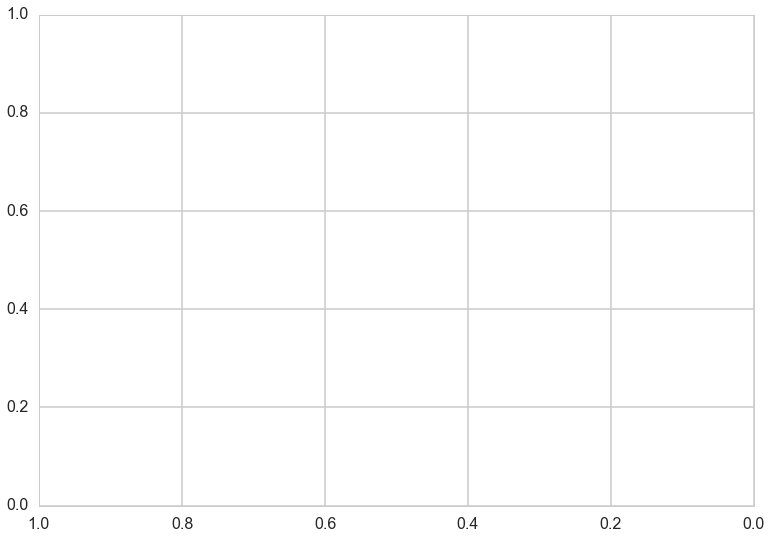

In [141]:
plt.gca().invert_xaxis()
plt.plot(nbrs, fmeanstr, color=c0, label="training");
plt.fill_between(nbrs, fmeanstr - fstdsstr, fmeanstr+fstdsstr, color=c0, alpha=0.3)
plt.plot(nbrs, fmeanste, color=c1, label="testing");
plt.fill_between(nbrs, fmeanste - fstdsste, fmeanste+fstdsste, color=c1, alpha=0.5)

plt.legend();

Note that the accuracy, while most likely not overfitted, does not appear to be very good. While more difficult to visualize, we thus follow up by classifying in the full feature space for both k=1 and k=50. Afterwards, we plot an error vs. complexity curve to find the appropriate k, as we wish to find a balance between high bias (large values of k) and high variance (small values of k).

In [48]:
ys=df_lab_change['status_group'].astype(int).values
subdf=df_lab_change.drop('status_group', axis=1)
subdfstd=(subdf - subdf.mean())/subdf.std()
Xs=subdfstd.values

In [49]:
classify(Xs,ys,1, plotit=False)

Accuracy on training data: 0.97
Accuracy on test data:     0.77


(1, 0.96647025813692478, 0.76586700336700342)

In [50]:
classify(Xs,ys,50, plotit=False)

Accuracy on training data: 0.75
Accuracy on test data:     0.73


(50, 0.75289001122334454, 0.73367003367003369)

In [60]:
%%time
classify(Xs,ys,25, plotit=False)

Accuracy on training data: 0.78
Accuracy on test data:     0.76
CPU times: user 9min 57s, sys: 5.89 s, total: 10min 3s
Wall time: 10min 25s


(25, 0.77831088664421999, 0.75597643097643097)

In [61]:
%%time
classify(Xs,ys,75, plotit=False)

Accuracy on training data: 0.74
Accuracy on test data:     0.73
CPU times: user 12min 4s, sys: 7.54 s, total: 12min 12s
Wall time: 12min 35s


(75, 0.73557800224466896, 0.72908249158249161)

In [75]:
%%time
## ALSO NEW
classify(Xs,ys,15, plotit=False)

Accuracy on training data: 0.80
Accuracy on test data:     0.76
CPU times: user 9min 27s, sys: 5.35 s, total: 9min 32s
Wall time: 9min 55s


(15, 0.79598765432098761, 0.76418350168350169)

In [ ]:
fits={}
for k in np.arange(1,45,7):
    fits[k]=[]
    for i in range(200):
        fits[k].append(classify(Xs, ys,k, False, False))
nbrs=np.arange(1,45,1)
fmeanstr = np.array([1.-np.mean([t[1] for t in fits[e]]) for e in nbrs])
fmeanste = np.array([1.-np.mean([t[2] for t in fits[e]]) for e in nbrs])
fstdsstr = np.array([np.std([t[1] for t in fits[e]]) for e in nbrs])
fstdsste = np.array([np.std([t[2] for t in fits[e]]) for e in nbrs])

As might be expected from classifying on the full feature space, we find evidence of overfitting. (The accuracy for the training data is much larger than that for the test data.) However, the overall accuracy even for the test data is much higher. 

Here, we may wish to play around with how many features we wish to select. 

## ALSO Optimize kNN with feature-selection?

In [ ]:
# #start kNN optimization with feature-selection here
# ys=df_lab_change['status_group'].astype(int).values
# # subdf=df_lab_change[['amount_tsh','gps_height','population','date_recorded_offset_days']]
# subdf=df_lab_change[['amount_tsh','date_recorded_offset_days']]
# # subdf=df_lab_change.drop('status_group', axis=1)
# #subdf=df[['pc1','pc2']]
# subdfstd=(subdf - subdf.mean())/subdf.std()
# Xs2=subdfstd.values

In [ ]:
## Toying with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=60)
X = pca.fit_transform(data)

print pca.explained_variance_ratio_.sum()

##Naive Bayes

We begin with Naive Bayes to set up a baseline classifier. While the probabilities may not be too well calibrated, the relative order of of the probabilities across the labels is typically correct.

Because we have a combination of categorical and continuous predictors, we first independently fit a Gaussian Naive Bayes model on the continuous data and a multinomial Naive Bayes model on the categorical part. Then we transform the entire dataset by taking the class assignment probabilities (with the predict_proba() method) as the new features: np.hstack((multinomial_probas, gaussian_probas)) and then refit a new model (e.g. a new gaussian NB) on these new features.

calibrate (show plot)
log -> sum

In [82]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB


#separate categorical and continuous
cont_feat_train = feat_train[STANDARDIZABLE]
cat_feat_train = feat_train.drop(STANDARDIZABLE,axis=1)
cont_feat_test = feat_test[STANDARDIZABLE]
cat_feat_test = feat_test.drop(STANDARDIZABLE,axis=1)

#fit the continuous variables to a Gaussian Naive Bayes
gnb_clf = GaussianNB()
gnb_clf.fit(cont_feat_train, lab_train)

#fit the categorical variables to a Multinomial Naive Bayes
mnb_clf = MultinomialNB()
mnb_clf.fit(cat_feat_train, lab_train)

gnb_probs = gnb_clf.predict_proba(cont_feat_train)
mnb_probs = mnb_clf.predict_proba(cat_feat_train)

feat_probs = np.hstack((gnb_probs, mnb_probs))

nb_clf = GaussianNB()
nb_clf.fit(feat_probs, lab_train)

#print "Frac of mislabeled points",float((yte != clf.predict(Xte)).sum())/yte.shape[0]
#confusion_matrix(clf.predict(Xte),yte)

/Users/lilyzhang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lilyzhang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lilyzhang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

First we fit a Bernoulli Naive Bayes model on the categorical classifiers only and measure the model's accuracy.

In [83]:
from sklearn.naive_bayes import BernoulliNB

#separate categorical and continuous


#fit the categorical variables to a Multinomial Naive Bayes
mnb_clf = BernoulliNB()
mnb_clf.fit(cat_feat_train, lab_train)

print "Frac of mislabeled points",float((lab_test != clf.predict(feat_test)).sum())/lab_test.shape[0]
confusion_matrix(clf.predict(feat_test),lab_test)

ValueError: could not convert string to float: Mar

##Regression

Because we have a categorical outcome variable with more than one outcome, we conduct a multinomial logistic regression with LASSO (specifically, L2) regularization.

Based on the visualizations up above, with 1. the wells shown in their respective geographic locations and 2. the proportion of functional/non functional/functional-needs-repair different across regions and subvillages, we sense that there may be some sort of clustering of wells by subvillage and region. Thus, we first create a multilevel model with two levels, one for the individual wells and the second for the subvillages. This creates a different correlation structure between the data points based on what group they are in.

In [49]:
##To run (classifier without optimizing for C)
mlr_clf = LogisticRegression(penalty="l2",solver='newton-cg', multi_class='multinomial')

In [53]:
mlr_clf = mlr_clf.fit(feat_train, lab_train)

/Users/lilyzhang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [54]:
training_accuracy = mlr_clf.score(feat_train, lab_train)
test_accuracy = mlr_clf.score(feat_test, lab_test)
print "############# based on standard predict ################"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
print confusion_matrix(lab_test, mlr_clf.predict(feat_test))
print "########################################################"

############# based on standard predict ################
Accuracy on training data: 0.74
Accuracy on test data:     0.73
[[8592   76 1045]
 [ 932   96  245]
 [2451   45 4338]]
########################################################


In [62]:
mlr_clf2 = LogisticRegression(penalty="l2",solver='newton-cg', multi_class='multinomial',C=10)
mlr_clf2 = mlr_clf2.fit(feat_train, lab_train)
training_accuracy = mlr_clf2.score(feat_train, lab_train)
test_accuracy = mlr_clf2.score(feat_test, lab_test)
print "############# based on standard predict ################"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
print confusion_matrix(lab_test, mlr_clf2.predict(feat_test))
print "########################################################"

############# based on standard predict ################
Accuracy on training data: 0.74
Accuracy on test data:     0.73
[[8590   78 1045]
 [ 931   97  245]
 [2449   46 4339]]
########################################################


/Users/lilyzhang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [57]:
feat_cols=list(df_indicators.columns)
feat_cols.remove(u'status_group')
clfmlr, Xtrain, ytrain, Xtest, ytest = do_classify(LogisticRegression(penalty="l2",solver='newton-cg', multi_class='multinomial'), 
            {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df_indicators,feat_cols, u'status_group',1, mask=mask)

using mask


/Users/lilyzhang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

To do:
-regularization hyperparameter
-calibration plot
-MLM
-Thresholdout

##Optimizing the hyperparameters

Now we write two functions: cv_optimize() use GridSearchCV to choose the best regularization hyperparameter for the model, and do_classify() to print out the model fit on the training and test sets.

In [18]:
def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    gs.fit(X, y)
    print "BEST:", gs.best_params_
    return gs.best_estimator_

Here, we use the score() function in sklearn.linear_model.LogisticRegression. Other model evaluation/comparison measures we could consider are the balanced F-score (sklearn.metrics.f1_score()), the Kappa Statistic, Confusion Matrix, Hamming Loss, and Zero One loss. More options can be found here: http://scikit-learn.org/stable/modules/model_evaluation.html. (#TODO if more time)

In [19]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

##Thresholdout

There is a problem with using and reusing the test set to estimate the accuracy of a model. Specifically, we run into problems of overfitting since we use the results of on test set to adapt the model over multiple iteration, so that when we fit to the test set the nth time, the model is no longer completely independent of the test set that helped refine it in the previous example. Based on the findings of a recent paper that came out in _Science_, "The reusable holdout: Preserving validity in adaptive data analysis," we run a Thresholdout, where we add noise to the holdout set, or test set, every time we use it. Based on the relative accuracy measurements on the test and training set, we take either the training set's accuracy measurement of the test set's accuracy measurement plus random noise. We have a maximum number of times we can iterate based on the variance we allow in our measurements and the size of the holdout set. More information can be found here: http://arxiv.org/pdf/1506.02629v1.pdf and https://www.sciencemag.org/content/349/6248/636.short.

We added this functionality to do_classify in the function do_classify2().

versions of optimizing:
- OLS (least bias)
- feature selection manually?
- regularization
    - ridge (posterior mean given a normal prior on the coefficients)
    - lasso (parameter shrinkage and selection; MAP given Laplace prior)

-use thresholdout to cross validation